<html>
<h1 style = "text-align : center; border : 1px black solid; padding : 20px;"> DL. Task 4. GAN</h1>

<h5 style = "text-align : right;">Louis Salomé</h5>

<br>Here are the main parts of this notebook :
1. + Get and properly read the code of GAN from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
   + Use FASHION MNIST dataset for training
2. + Rewrite GAN class so that it can change count of batches per generator and discriminator : standart realization provides 1-1 (1 batch per generator (N_gen = 1) and, then, 1 batch per discriminatror (N_disc = 1))
   + Setup N_gen and N_disc and try to find the best ones
   + As the result prepare generated matrices (example below) for each configuration on N_gen - N_disc


In [10]:
### import part

# Process data
import numpy as np

# Plot graphics
import matplotlib
from matplotlib import pyplot as plt

# Load Data
import keras
from keras.datasets.fashion_mnist import load_data

# Randomness
import random as rd

# Neural Networks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

# tensorflow
import tensorflow as tf

# Use only one of the 4 GPUs
# Using the command nvidia-sim we can chose the freest GPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3' # Here is the NUMBER_OF_GPU
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


# 1. A generative adversarial network class

In [11]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        #model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        #model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, N_gen, N_disc,batch_size=128, sample_interval=500): 

        # Load the dataset
        (X_train, _), (_, _) = load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            for i in range(N_disc):
                
                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            for i in range(N_gen):

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            #if epoch % sample_interval == 0:
            #    self.sample_images(epoch)
            
    def sample_images(self, N_gen, N_disc, doesItPlot = False, doesItSave = False):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        
        if (doesItPlot == True):
            plt.show()
        
        if (doesItSave == True):
            fileName = "gen"+str(N_gen)+"&disc"+str(N_disc)
            fig.savefig("images/"+fileName+".png")
            plt.close()
        

Initialize a GAN, train it, and plot examples of predictions

/media/disk2/lsalome/env3/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


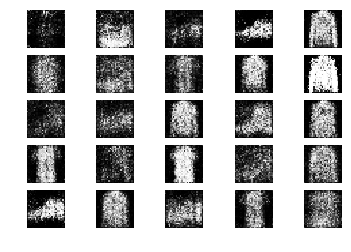

CPU times: user 1min 37s, sys: 6.7 s, total: 1min 44s
Wall time: 15.4 s


In [3]:
%%time
# This cell is used to create and train GAN.
# With 5000 epochs it takes 10 minutes to perform it

RunItAgain = True
if( __name__ == '__main__' and RunItAgain):
    gan = GAN()
    gan.train(epochs=800,
              N_gen=1,
              N_disc = 1,
              batch_size=32, 
              sample_interval=200)
    gan.sample_images(N_gen=1,N_disc=1,doesItPlot=True)

# 2. Tuning count of batches

We will train on 40 000 batches of 32 images with $40000\times\frac{N_{gen}}{N_{gen}+N_{disc}}$ batches for generator and  $40000\times\frac{N_{disc}}{N_{gen}+N_{disc}}$ for the discriminant. So that the running time will be approximately the same and the same total number of- trainings will be performed.

In [12]:
# searching space
all_N_gen = [i for i in range(1,6)]
all_N_disc = [i for i in range(1,6)]
already_tested_grid = []


def testGAN(params):
# define a function that will test a set of parameter (i.e. a pair N_gen, N_disc)
    
    # initisalise GAN
    gan = GAN()

    # train GAN
    gan.train(epochs=int(20000 / ((params['N_gen']+params['N_disc'])/2)), 
              N_gen = params['N_gen'],
              N_disc = params['N_disc'],
              batch_size=32, 
              sample_interval=200)
    
    # print informations about current parameters
    print("*********************\n"+
          "N_gen :",params['N_gen'],
         "\nN_disc :",params['N_disc'])
    
    # plot & save results
    gan.sample_images(N_gen=params['N_gen'],N_disc=params['N_disc'],doesItPlot=True,doesItSave=True)
    pass


def testRandom(N_iter):
# define a function to loop through all possibilities
# by random search

    # loop N_iter times
    for i in range(N_iter):
        
        #chose parameters
        is_it_a_new_grid = False
        grid = {
            'N_gen': rd.choice(all_N_gen),
            'N_disc':  rd.choice(all_N_disc)
        }
        while grid in already_tested_grid :
            grid = {
            'N_gen': rd.choice(all_N_gen),
            'N_disc':  rd.choice(all_N_disc)
        }
        already_tested_grid.append(grid)
        
        # do the test
        testGAN(grid)
    pass

/media/disk2/lsalome/env3/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


*********************
N_gen : 1 
N_disc : 2


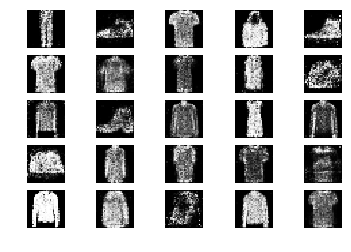

*********************
N_gen : 4 
N_disc : 1


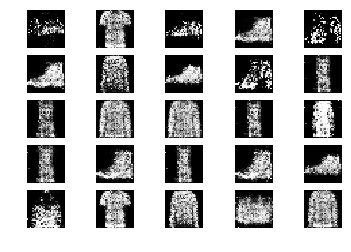

*********************
N_gen : 5 
N_disc : 2


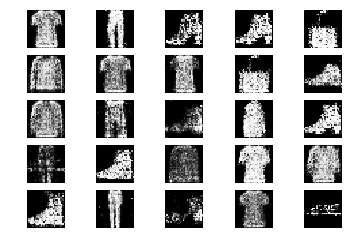

*********************
N_gen : 3 
N_disc : 5


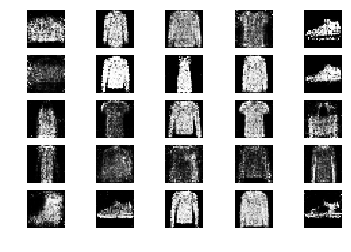

*********************
N_gen : 2 
N_disc : 3


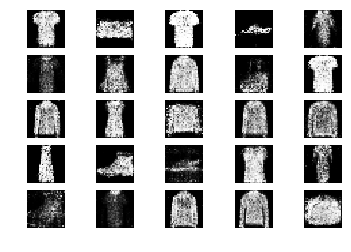

In [ ]:
%%time
# RUN IT
testRandom(5)

/media/disk2/lsalome/env3/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


*********************
N_gen : 2 
N_disc : 5


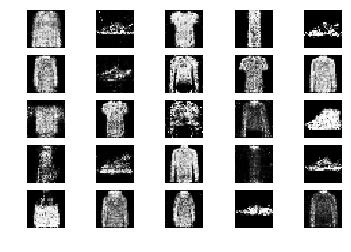

*********************
N_gen : 4 
N_disc : 3


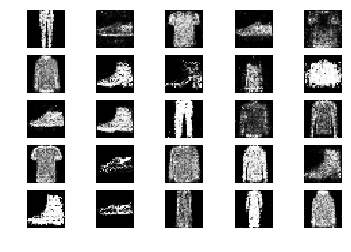

*********************
N_gen : 3 
N_disc : 4


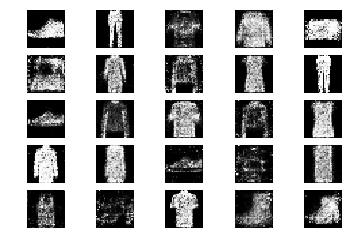

*********************
N_gen : 4 
N_disc : 2


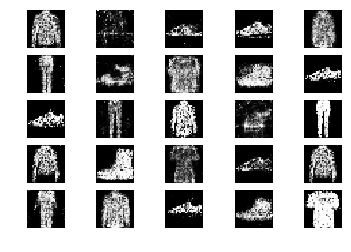

*********************
N_gen : 1 
N_disc : 1


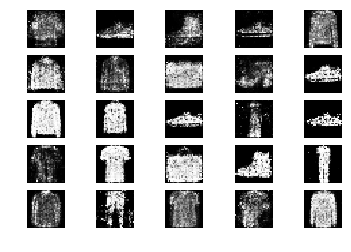

CPU times: user 3h 18min 56s, sys: 12min 12s, total: 3h 31min 9s
Wall time: 26min 37s


In [13]:
%%time
# RUN IT
testRandom(4)